<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/cGAN_2(actual_implementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


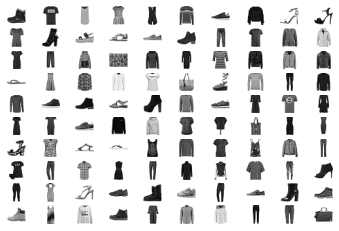

In [3]:
import matplotlib.pyplot as plt
for i in range(100):
  plt.subplot(10,10,(i+1))
  plt.axis('off')
  plt.imshow(train_images[i], cmap='gray_r')

In [4]:
from tensorflow.keras.layers import Embedding, Conv2D, Conv2DTranspose, Input, LeakyReLU, Flatten, Dense, Reshape, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
n_class=10; out_shape=50
lEx=Embedding(input_dim=n_class, output_dim=out_shape)(Input(shape=(1,)))
lEx.shape

TensorShape([None, 1, 50])

In [6]:
def build_discriminator():
  inp_l=Input(shape=(1,))
  l1=Embedding(input_dim=10, output_dim=50)(inp_l)
  l2=Dense(units=28*28)(l1)
  lr=Reshape(target_shape=(28,28,1))(l2)
  inp_i=Input(shape=(28,28,1))
  c=Concatenate()([lr, inp_i])
  l3=Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same')(c)
  lr=LeakyReLU(alpha=0.2)(l3)
  l4=Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(lr)
  lr=LeakyReLU(alpha=0.2)(l4)
  l5=Flatten()(lr)
  l6=Dropout(0.4)(l5)
  l7=Dense(1, activation='sigmoid')(l6)
  model=Model(inputs=[inp_l, inp_i], outputs=l7)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

disc=build_discriminator()

In [7]:
disc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
______________________________________________________________________________________________

In [8]:
def build_generator(latent_dim):
  input1=Input(shape=(1,))
  input_1=Embedding(input_dim=10, output_dim=50)(input1)
  input_1=Dense(7*7)(input_1)
  input_1=Reshape(target_shape=(7,7,1))(input_1)

  input2=Input(shape=latent_dim)
  input_2=Dense(128*7*7)(input2)
  input_2=LeakyReLU(alpha=0.2)(input_2)
  input_2=Reshape(target_shape=(7,7,128))(input_2)

  c=Concatenate()([input_1, input_2])
  l1=Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same')(c)
  lr=LeakyReLU(alpha=0.2)(l1)
  l2=Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same')(lr)
  lr=LeakyReLU(alpha=0.2)(l2)
  lf=Conv2D(1, kernel_size=(7,7), padding='same')(lr)
  model=Model(inputs=[input1, input2], outputs=lf)
  return model
  
gen=build_generator(100)

In [9]:
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_5[0][0]                    
____________________________________________________________________________________________

In [10]:
def build_gan():
  input_label, input_noise=gen.input
  model1=gen([input_label, input_noise])
  model2=disc([input_label, model1])
  model=Model(inputs=[input_label, input_noise], outputs=model2)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

gan=build_gan()

In [11]:
disc.trainable=False
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 28, 28, 1)    1169336     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1)            196773      input_4[0][0]              

In [12]:
train_images=train_images.astype('float32')
train_images=(train_images-127.5)/127.5

In [13]:
import numpy as np

In [14]:
def generate_real_samples(n_samples):
  ix=np.random.randint(0, train_images.shape[0], n_samples)
  x_labels=train_labels[ix]
  x_images=train_images[ix]
  y=np.ones(shape=(n_samples,1))
  return [x_labels, x_images], y

In [15]:
[x_l, x_i], y=generate_real_samples(10)
x_l.shape, x_i.shape, y.shape

((10,), (10, 28, 28), (10, 1))

In [16]:
def generate_latent_points(n_samples):
  x_input=np.random.randn(100*n_samples)
  x_input=x_input.reshape((n_samples, 100))
  x_labels=np.random.randint(0, 10, n_samples)
  return x_input, x_labels

def generate_fake_samples(n_samples):
  input_noise, input_labels=generate_latent_points(n_samples)
  x_images=gen.predict([input_labels, input_noise])
  y=np.zeros(shape=(n_samples,1))
  return [input_labels, x_images], y

[in_l, x_i], y=generate_fake_samples(10)

In [17]:
x_i, x_l=generate_latent_points(2)
gan.predict([x_l, x_i])

array([[0.4992796 ],
       [0.49897653]], dtype=float32)

In [18]:
in_l.shape, x_i.shape, y.shape

((10,), (2, 100), (10, 1))

In [19]:
real_loss, fake_loss, gen_loss=[],[],[]

In [20]:
def train(epochs=100, n_batch=128):
  batch_per_epoch=train_images.shape[0]//n_batch
  half_batch=n_batch//2
  for i in range(epochs):
    for j in range(batch_per_epoch):
      [x_real_labels, x_real], y_real=generate_real_samples(half_batch)
      d_loss1,_ =disc.train_on_batch(x=[x_real_labels, x_real], y=y_real)
      [x_fake_labels, x_fake], y_fake=generate_fake_samples(half_batch)
      d_loss2,_ =disc.train_on_batch(x=[x_fake_labels, x_fake], y=y_fake)
      in_noise, in_labels=generate_latent_points(n_batch)
      y_gan=np.ones(shape=(n_batch,1))
      gan_loss,_ =gan.train_on_batch([in_labels, in_noise], y_gan)
      real_loss.append(d_loss1)
      fake_loss.append(d_loss2)
      gen_loss.append(gan_loss)
      print('%d %d d_loss1[%.3f] d_loss2[%.3f] gan_loss[%.3f]'%(i+1, j+1, d_loss1, d_loss2, gan_loss))

In [21]:
train(5)

1 1 d_loss1[0.743] d_loss2[0.694] gan_loss[0.693]
1 2 d_loss1[0.642] d_loss2[0.703] gan_loss[0.684]
1 3 d_loss1[0.562] d_loss2[0.717] gan_loss[0.670]
1 4 d_loss1[0.489] d_loss2[0.747] gan_loss[0.644]
1 5 d_loss1[0.412] d_loss2[0.800] gan_loss[0.601]
1 6 d_loss1[0.327] d_loss2[0.899] gan_loss[0.541]
1 7 d_loss1[0.282] d_loss2[1.041] gan_loss[0.466]
1 8 d_loss1[0.233] d_loss2[1.249] gan_loss[0.393]
1 9 d_loss1[0.217] d_loss2[1.490] gan_loss[0.327]
1 10 d_loss1[0.208] d_loss2[1.744] gan_loss[0.283]
1 11 d_loss1[0.213] d_loss2[1.951] gan_loss[0.264]
1 12 d_loss1[0.217] d_loss2[2.063] gan_loss[0.257]
1 13 d_loss1[0.221] d_loss2[2.037] gan_loss[0.281]
1 14 d_loss1[0.238] d_loss2[1.942] gan_loss[0.331]
1 15 d_loss1[0.234] d_loss2[1.933] gan_loss[0.414]
1 16 d_loss1[0.270] d_loss2[1.647] gan_loss[0.513]
1 17 d_loss1[0.264] d_loss2[1.610] gan_loss[0.608]
1 18 d_loss1[0.248] d_loss2[1.424] gan_loss[0.695]
1 19 d_loss1[0.252] d_loss2[1.238] gan_loss[0.765]
1 20 d_loss1[0.254] d_loss2[1.176] gan_l

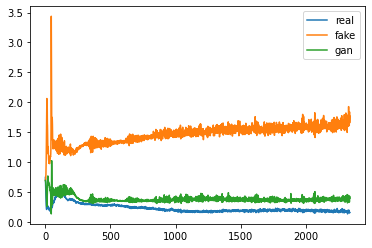

In [22]:
def plot_history():
  plt.plot(real_loss, label='real')
  plt.plot(fake_loss, label='fake')
  plt.plot(gen_loss, label='gan')
  plt.legend()
plot_history()

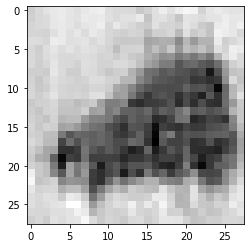

In [28]:
labels=np.random.randint(0,10,2)
noise=np.random.randn(100*2)
noise=noise.reshape(2,100)
out=gen.predict([labels, noise])
plt.imshow(out[0].reshape(28,28), cmap='gray_r')

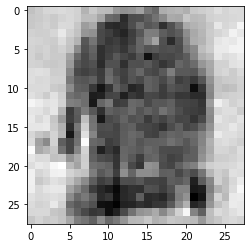

In [29]:
plt.imshow(out[1].reshape(28,28), cmap='gray_r')